# **Torchvision Mask R-CNN**

This is a [Mask R-CNN](https://arxiv.org/abs/1703.06870) colab notebook using [torchvision](https://pytorch.org/docs/stable/torchvision/index.html).

For other deep-learning Colab notebooks, visit [tugstugi/dl-colab-notebooks](https://github.com/tugstugi/dl-colab-notebooks).

### **1. Import Labraries**

In [1]:
import os
from os.path import exists, join, basename, splitext
import random
import PIL
import torchvision
import cv2
import numpy as np
import torch
torch.set_grad_enabled(False)

import time
import matplotlib.pylab as pll
pll.rcParams['axes.grid'] = False

### **2. Initialize Mask R-CNN and download pretrained weights**

In [2]:
model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights = True)
model = model.eval().cuda()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth
100%|██████████| 170M/170M [00:02<00:00, 78.5MB/s]


### **3. Detect objects on a test image**

**First, dowload a test image from internet:**

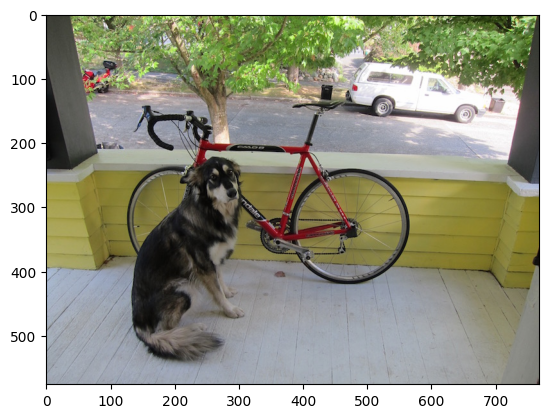

In [4]:
IMAGE_URL = 'https://raw.githubusercontent.com/tugstugi/dl-colab-notebooks/master/resources/dog.jpg'

import matplotlib
image_file = basename(IMAGE_URL)
!wget -q -O {image_file} {IMAGE_URL}
pll.imshow(matplotlib.image.imread(image_file))

**Execute Mask R-CNN model on that image and show the result:**

In [6]:
t = time.time()
image = PIL.Image.open(image_file)
image_tensor = torchvision.transforms.functional.to_tensor(image).cuda()
output = model([image_tensor])[0]
print('executed in %.3fs' % (time.time() - t))

executed in 2.214s


In [10]:
coco_names = ['unlabeled', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'street sign', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'hat', 'backpack', 'umbrella', 'shoe', 'eye glasses', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'plate', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'mirror', 'dining table', 'window', 'desk', 'toilet', 'door', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'blender', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']
colors = [[random.randint(0, 255) for _ in range(3)] for _ in coco_names]

result_image = np.array(image.copy())
for box, label, score in zip(output['boxes'], output['labels'], output['scores']):
  if score > 0.5:
    color = random.choice(colors)

    # Draw box
    tl = round(0.002 * max(result_image.shape[0:2])) + 1 # line thickness
    c1, c2 = (int(box[0]), int(box[1])), (int(box[2]), int(box[3]))
    cv2.rectangle(result_image, c1, c2, color, thickness = tl)

    # draw text
    display_txt = "%s: %.1f%%" % (coco_names[label], 100*score)
    tf = max(tl - 1, 1) # font thickness
    t_size = cv2.getTextSize(display_txt, 0, fontScale = tl/3, thickness = tf)[0]
    c2 = c1[0] + t_size[0], c1[1] - t_size[1] - 3
    cv2.rectangle(result_image, c1, c2, color, -1) # filled
    cv2.putText(result_image, display_txt, (c1[0], c1[1] - 2), 0, tl/3, [255, 255], thickness = tf, lineType = cv2.LINE_AA)

pll.figure(figsize = (20, 15))
pll.imshow(result_image)

Output hidden; open in https://colab.research.google.com to view.

**Show masks for the above objects:**

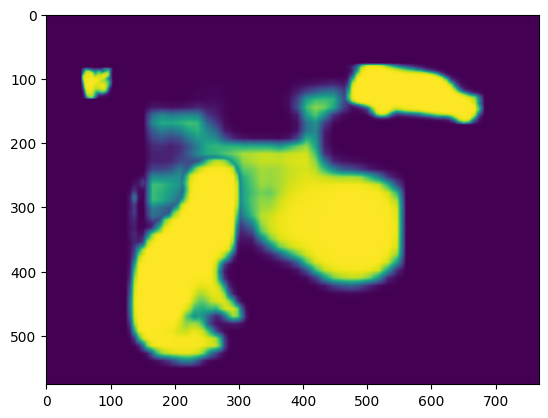

In [12]:
masks = None
for score, mask in zip(output['scores'], output['masks']):
  if score > 0.5:
    if masks is None:
      masks = mask
    else:
      masks = torch.max(masks, mask)

pll.imshow(masks.squeeze(0).cpu().numpy())